<div class="alert alert-info" role="alert">
  <hr> <center> <font size="+3.5"> <b> Interpréter des conditions atypiques à l'aide d'autoencodeurs variationnels conditionnels </b> </font> </center> <hr>
</div>

<div class="alert alert-block" role="alert">
    <center><b> <u>Auteur :</u>  Clement GOUBET  </b></center>
</div>
<div class="alert alert-block" role="alert">
    <center> <font size="+1.5"> <b>  23 juillet 2019  </b>  </font> </center>
</div>

# Table de contenu

## 0. Préparation de l'environnement de travail
- chargement des modules
- mise en forme des données
- définition de quelques fonctions utiles

## 1. Premier modèle VAE
- construction du modèle
- entrainement
- évaluation de la représentation obtenue
- premières interprétations

## 2. Modèle CVAE
- construction du modèle
- entrainement
- évaluation de la représentation obtenue
- premières interprétations
- analyse spécifique jours fériés et points atypiques

<div class="alert alert-info" role="alert">
    <font size="+2"> <b> 0. Preparation de l'environnement de travail </b> </font> <hr>
</div>

# Chargement des modules et mise en forme des données

In [1]:
#import external libraries
import sys
import os
import datetime
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
import seaborn as sn
from scipy import stats
import cv2 #from open-cv, to convert array to images
from IPython.display import Image
from tensorflow.keras.callbacks import TensorBoard
from time import time
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf


In [3]:
#paths in git

#root git folder 
path_main_folder = '/home/goubetcle/Documents/Git/Autoencoder_Embedding_Expert_Caracteristion_'
#path_main_folder = '/home/jovyan'#specify the root folder of the git repo

#add  to path root git folder 
sys.path.append(path_main_folder)
#add  to path source code folder
sys.path.append(path_main_folder+'/src')

In [4]:
#import class and methods from src
from tensorflow.keras import backend as K
from CVAE.callbacks import *
#from CVAE.cvae import compile_cvae, run_cvae
from conso.load_shape_data import *

import Visualisation.buildProjector
from Visualisation.buildProjector import *
from FeaturesScore.scoring import *
from FeaturesScore.exploration import *

#from conso.load_shape_data import get_x_conso_autoencoder
from conso.conso_helpers import plot_latent_space_projection, pyplot_latent_space_projection_temp, pyplot_latent_space_projection_error


Les données de consommation et de température sont des prises de mesure par pas de temps 30 minutes pendant 5 années de décembre 2012 à décembre 2017. 

In [5]:
# Load dataframe
path_data = os.path.join(path_main_folder, 'data')
dataset_csv = os.path.join(path_data, "dataset.csv")
x_conso = pd.read_csv(dataset_csv, sep=",",)
x_conso.ds = pd.to_datetime(x_conso.ds)

#drop indices column
x_conso=x_conso.drop(columns=x_conso.columns[0],axis=1)

#Visualize data frame head
x_conso.tail(5)

,ds,consumption_France,temperature_France,is_holiday_day
87825,2017-12-31 21:30:00,56505.0,9.306475,0.0
87826,2017-12-31 22:00:00,56000.0,9.097250,0.0
87827,2017-12-31 22:30:00,56995.0,9.048775,0.0
87828,2017-12-31 23:00:00,60395.0,9.000300,0.0
87829,2017-12-31 23:30:00,60230.0,9.000300,0.0


On s'intéresse ici à caractériser les profils journaliers. L'ensemble de données est donc transformé pour que notre jeu d'entrée soit ait en colonnes les points de mesure journaliers de la consommation d'électricité. Avant cela, il est ici normalisé sur l'ensemble des mesures.

In [6]:
name_set_plot = 'train'
version = '-v1'
nPoints=1830

dict_xconso = {'train': x_conso}

# Normalize input variables
type_scaler = 's'
dict_xconso, _ = normalize_xconso(dict_xconso, type_scaler = 'standard')

['consumption_France']


In [7]:
dataset = get_dataset_autoencoder(dict_xconso=dict_xconso)


Le dictionnaire dataset contient toutes les informations nécessaires à l'entrainement des modèles :
- dataset['train']['x'] contient la liste des entrées de l'encodeur:
-- [0] les profils de consommations
-- [1] les conditions passées en entrée de l'encodeur et du décodeur pour rendre la représentation latente plus indépendante de ces variables
- dataset['train']['y'] contient une copie des profils des consommation (pointeur pour le calcul des pertes de reconstruction dans l'apprentissage des modèles)
- dataset['train']['ds'] contient les dates des exemples

Pour interpréter notre représentation, on peut chercher à visualiser des paramètres connus associés à nos profils journaliers. Ici il s'agit notamment de données calendaires (mois, weekend, jour férié), auxquels on peut rajouter la température moyenne observée sur la journée (par exemple), ou encore la pente moyenne du profil.

Ces informations sont à passer dans calendar_info pour être visualisés dans une projection Tensorboard, et à passer en type et en valeur respectivement dans le dictionnaire factorDesc et factorMatrix pour servir dans l'évaluation des latents. 

In [8]:
#importation des données calendaires
calendar_info = pd.DataFrame(dataset[name_set_plot]['ds'])
calendar_info['month'] = calendar_info.ds.dt.month
calendar_info['weekday'] = calendar_info.ds.dt.weekday
calendar_info['is_weekday'] = (calendar_info.weekday < 5).apply(lambda x:int(x))
calendar_info = pd.merge(calendar_info, x_conso[['ds', 'is_holiday_day']], on='ds', how ='left')
calendar_info.loc[calendar_info['is_holiday_day'].isna(),'is_holiday_day'] = 0
calendar_info['year'] = calendar_info.ds.dt.year


In [9]:
calendar_info

,ds,month,weekday,is_weekday,is_holiday_day,year
0,2012-12-28,12,4,1,0.0,2012
1,2012-12-29,12,5,0,0.0,2012
2,2012-12-30,12,6,0,0.0,2012
3,2012-12-31,12,0,1,0.0,2012
4,2013-01-01,1,1,1,1.0,2013
...,...,...,...,...,...,...
1825,2017-12-27,12,2,1,0.0,2017
1826,2017-12-28,12,3,1,0.0,2017
1827,2017-12-29,12,4,1,0.0,2017
1828,2017-12-30,12,5,0,0.0,2017


In [10]:
#importation des données météo
meteo1_csv = os.path.join(path_data, "meteo_events.csv")
meteo2_csv = os.path.join(path_data, "meteo_events_2.csv")

meteo_events1 = pd.read_csv(meteo1_csv)
meteo_events2 = pd.read_csv(meteo2_csv)
meteo_events = meteo_events1.append(meteo_events2)
events = ['snow', 'floods', 'storm', 'hurricane', 'heavy_rains', 'cold', 'hot']
meteo_records=pd.DataFrame(data=np.zeros((nPoints, len(events))), columns=events)
from datetime import *
for k in range(meteo_events.shape[0]):
    day = datetime.strptime(meteo_events.iloc[k,0],'%Y-%m-%d')
    cld = np.asarray(calendar_info.ds.dt.date)
    row = np.where(cld==day.date())[0]
    meteo_records.iloc[row,:]+=np.asarray(meteo_events.iloc[k,2:-1])
    duration = int(meteo_events.iloc[k,1])
    if duration != 0:
        for i in range(duration):
            day_inc = timedelta(days=i+1)+day
            cld = np.asarray(calendar_info.ds.dt.date)
            row = np.where(cld==day_inc.date())[0]
            meteo_records.iloc[row,:]+=np.asarray(meteo_events.iloc[k,2:-1])

meteo_records.iloc[:,:] = 1*(meteo_records.iloc[:,:]>0)

In [11]:
meteo_records.describe()

,snow,floods,storm,hurricane,heavy_rains,cold,hot
count,1830.000000,1830.000000,1830.000000,1830.000000,1830.000000,1830.000000,1830.000000
mean,0.092350,0.077049,0.087432,0.068852,0.087432,0.074863,0.157377
std,0.289598,0.266742,0.282544,0.253272,0.282544,0.263243,0.364255
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
#Study conso variations as importance factors
slope = np.abs(np.diff(dataset['train']['x'][0]))
#variationMax = np.max(slope, axis=1)
variationMean = np.mean(slope, axis = 1)
#calendar_info['load_variation_max'] = variationMax
calendar_info['load_variation_mean'] = variationMean

In [13]:
#explicit the potential bridge days taken as extended holidays
day_hol = calendar_info[['weekday', 'is_holiday_day']].copy().values
bridge_index=[]
for i in range(day_hol.shape[0]):
    if day_hol[i,1]==1:
        if day_hol[i,0]==1:
            bridge_index.append(i-1)
        elif day_hol[i,0]==3:
            bridge_index.append(i+1)

bridges = np.zeros(day_hol.shape[0])
bridges[np.asarray(bridge_index)] = 1

calendar_info['potential_bridge_holiday'] = bridges
#calendar_info['potential_bridge_holiday'].describe()

In [14]:
factors = calendar_info.iloc[:,1:5].copy()
columns_x = x_conso.columns
conso_idx = np.argmax(['consumption' in c for c in x_conso.columns])
temp_idx = np.argmax(['temperature' in c for c in x_conso.columns])
dates = np.unique(x_conso['ds'].dt.date)
temperatureMean=np.asarray([np.mean(x_conso[columns_x[temp_idx]].iloc[np.where(x_conso['ds'].dt.date==dates[k])]) for k in range(dates.shape[0])])

factorMatrix = np.c_[factors.values,temperatureMean]

factorDesc={
    'month':'category',
    'weekday':'category',
    'is_weekday':'category',
    'is_holiday_day':'category',
    'temperature':'regressor'
}

In [15]:
meteo_records

,snow,floods,storm,hurricane,heavy_rains,cold,hot
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...
1825,0,0,0,0,0,0,0
1826,0,0,0,0,0,0,0
1827,0,0,0,0,0,0,0
1828,0,0,0,0,0,0,0


# Tools to evaluate the representations

In [16]:
#visualisation des metriques
def display_metrics(model_eval, z_dim, factorDesc):
    if 'reconstruction_error' in model_eval.keys():
        for k,v in model_eval['reconstruction_error'].item():
            print(k, ' : ', v)
    print('Mutual Information Gap : %.2f'%model_eval['mig'])

    fig = plt.figure(dpi=100,figsize=(10,8))

    plt.subplot(2, 3, 1)
    fig.subplots_adjust(hspace=0.5)
    plt.bar(factorDesc.keys(),model_eval['informativeness'])
    plt.xlabel('factors')
    plt.xticks(rotation=75)
    plt.ylim(top=1)
    for index,data in enumerate(model_eval['informativeness']):
        plt.text(x=index - 0.5, y =data+0.01 , s="%.2f"%data , fontdict=dict(fontsize=10))
    plt.title('Informativeness score : %.2f'%np.mean(model_eval['informativeness']))

    plt.subplot(2, 3, 2)
    plt.bar(np.arange(z_dim)+1,np.log(6)*model_eval['disentanglement'])
    plt.xlabel('latent variables')
    plt.title('Disentanglement score : %.2f'%model_eval['mean_disentanglement']);

    plt.subplot(2, 3, 3)
    plt.bar(factorDesc.keys(),model_eval['compactness'])
    plt.xlabel('factors')
    plt.xticks(rotation=75)
    plt.title('Compactness')
    plt.tight_layout();
    
    plt.subplot(2, 3, 5)
    plt.bar(np.arange(z_dim)+1,1-model_eval['modularity'])
    plt.xlabel('latent variables')
    plt.title('Modularity score : %.2f'%np.mean(1-model_eval['modularity']));

In [17]:
from math import cos, sin
#visualisation d'une représentation 2D dans le notebook
def prez_2D(x_encoded):
    proj2D = PCA(2)
    proj = proj2D.fit_transform(x_encoded)
    plt.figure(figsize=(36,18))
    
    #visualisation des mois par un disque de fond coloré
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,1]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= factorMatrix[index,0], marker = 'o', s=500, alpha=0.5, cmap = 'Paired')

    plt.colorbar().set_label('month');
    
    #visualisation de la température par la coloration graduelle du jour de la semaine
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,1]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= temperatureMean[index], marker = '$'+str(i)+'$', s=200)

    plt.colorbar().set_label('temperature');
    
def prez_3D(x_encoded):
    proj3D = PCA(3)
    proj_z = proj3D.fit_transform(x_encoded)
    plt.figure(figsize=(36,18))
    
    proj = proj_z[:,:2]
    third = proj_z[:,2]
    
    proj = proj + np.tile(third.reshape(-1,1), (1,2)) * np.tile(np.array([[-cos(0.785),sin(0.785)]]),(nPoints,1))
    
    size = 300  + (1.- np.exp(-third / max(third))) * 800
    #visualisation des mois par un disque de fond coloré
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,1]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= factorMatrix[index,0], marker = 'o', s=size, alpha=0.5, cmap = 'Paired')

    plt.colorbar().set_label('month');
    
    #visualisation de la température par la coloration graduelle du jour de la semaine
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,1]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= temperatureMean[index], marker = '$'+str(i)+'$', s=200)

    plt.colorbar().set_label('temperature');

Pour créer une représentation sous tensorboard, la fonction suivante regroupe toutes les étapes. Le booléen includeConsuptionProfileImages active ou non le marqueur des points à l'image des profils de consommation.

In [18]:
def tensorboardProjection(name_model,x, x_hat, x_encoded, x_conso, calendar_info, log_dir_projector, includeConsumptionProfileImages=True):
    #can take a bit longer to create and load in tensorboard projector, but it looks better in the projector
    if includeConsumptionProfileImages:
        nPoints=1500 #if you want to visualize images of consumption profiles and its recontruction in tensorboard, there is a maximum size that can be handle for a sprite image. 1830 is  
        x_encoded_reduced=x_encoded[0:nPoints,]
        images=createLoadProfileImages(x,x_hat,nPoints)
    else:
        nPoints=1830
        
    if includeConsumptionProfileImages:
        sprites=images_to_sprite(images)
        cv2.imwrite(os.path.join(log_dir_projector, 'sprite_4_classes.png'), sprites)
    
    writeMetaData(log_dir_projector,x_conso,calendar_info,nPoints,has_Odd=False)
    if includeConsumptionProfileImages:
        buildProjector(x_encoded_reduced,images=images, log_dir=log_dir_projector)
    else:
        buildProjector(x_encoded,images=None, log_dir=log_dir_projector)
        
    print(log_dir_projector)

In [19]:
#Visualisation des courbes de charge en entrée et reconstruite par le modèle
mean_sc, var_sc = stats.describe(x_conso.consumption_France)[2:4]
std_sc = np.sqrt(var_sc)
def display_loads(x, x_hat,date,mae):
    fig = plt.figure(dpi=100,figsize=(5,5))
    #set(gca,'Color','k')
    plt.plot(x*std_sc+ mean_sc, label = 'truth')
    plt.plot(x_hat*std_sc+ mean_sc, '--', label = 'reconstruction')
    plt.title(date+' - mean absolute error %0.2f GW' %(mae*std_sc/1000))
    plt.xlabel('hours')
    plt.ylabel('load (MW)')
    plt.xlim((0,48))
    plt.xticks([5,11,17,23,29,35,41], [3,6,9,12,15,18,21])
    plt.legend(loc='lower right')
    plt.grid();

<div class="alert alert-info" role="alert">
    <font size="+2"> <b> 1. Un modèle classique </b> </font> <hr>
</div>

## Rappels

Les autoencodeurs variationnels sont des modèles qui fonctionnent en duo:
- un encodeur qui traduit les données d'entrée dans un espace latent de dimension arbitrairement choisie. Plus exactement il cherche les paramètres de distribution des variables latentes dans chacune des dimensions.
- un decodeur qui cherche à reconstruire les entrées à partir des coordonnées dans l'espace latent

Pendant l'appentissage, le lien entre encodeur et decodeur est réalisé par l'échantillage selon les paramètres de distribution appris : chaque échantillon a des coordonnées latentes tirées aléatoirement selon cette dernière, que le décodeur cherche à retraduire dans l'espace de dimension initial. 

## Construire et entrainer un modèle VAE

Il s'agit dans un premier temps de paramétrer les dimensions des couches de nos réseaux de neurone:
- celles de l'encodeur e_dim
- celles du décodeur d_dims
- les dimensions de notre espace latent z_dim (chaque paramètre de distribution sera donc aussi de dimension z_dim)

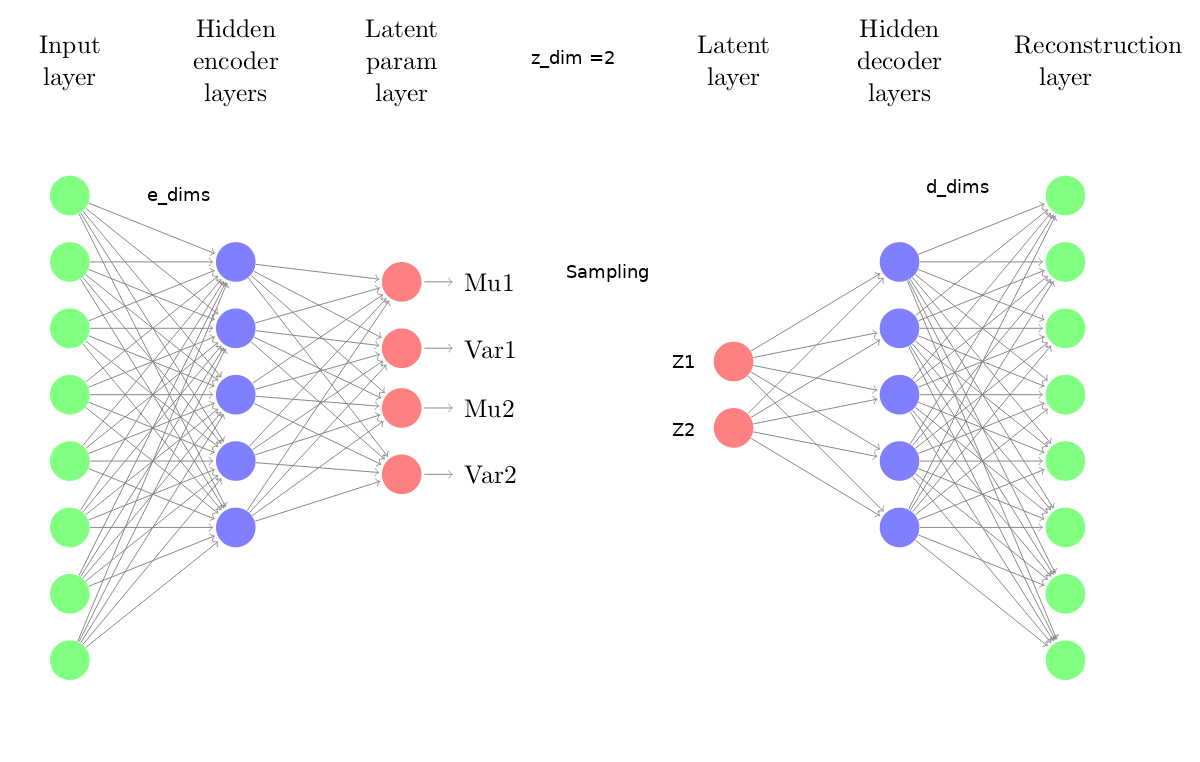

In [20]:
Image(path_main_folder+'/images/VAE.png', width=1000, height=150)

In [21]:
# paramètres de l'autoencodeur
z_dim = 4 # le nombre de dimensions voulues dans notre représentation latente
e_dims=[48,48,24,12]# les couches cachées du bloc encodeur; premier nombre = inputs_dim
d_dims=[48,24,12]# les couches cachées du bloc decodeur; premier nombre = outputs_dim
lr=3e-4 # le learning rate de l'optimiseur
input_dim = dataset['train']['x'][0].shape[1]

Pour les paramètres liés au modèle, il faut rappeler le fonctionnement du VAE. On cherche la maximisation de la borne inférieure de la log-vraissemblance du modèle reconstruit ou ELBO qui se décompose en deux termes :

ELBO $= \mathbb{E}_{q_\phi(z|x)} \log(p_\theta(x|z)) - KL(q_\phi(z|x) \| p(z))$

Dans notre objectif d'apprentissage, cela est traduit par une perte à minimiser de la forme:

Obj $= \|x - \hat{x}\| +  KL(q_\phi(z|x) \| p(z))$.

- L'erreur de reconstruction peut être choisie selon une mesure en norme L1 ou L2. La norme L1 permet notamment d'obtenir des profils avec moins de valeurs abérrantes.

- Un prior $p(z)$ laplacien plutôt que gaussien permet des concentrations plus piquées des groupements similaires, et renvoie plus loin les points atypiques. 

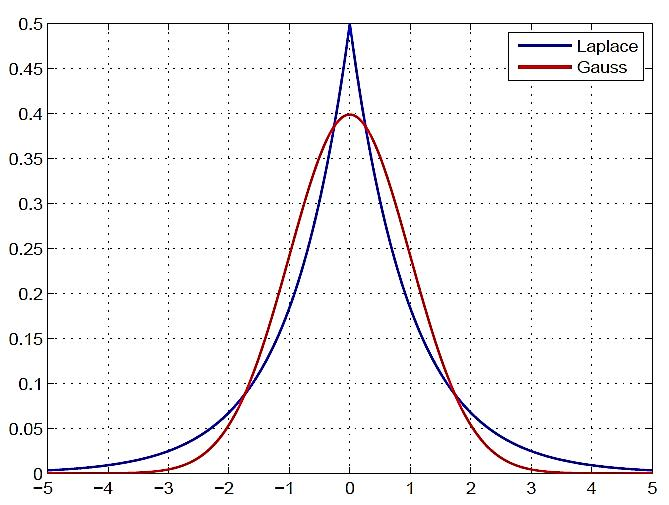

In [22]:
Image(path_main_folder+'/images/lois_laplace_normale.jpg', width=500)


- Par ailleurs, pour faciliter l'apprentissage du modèle de façon structurée dans les dimensions choisies de l'espace latent, l'action peut se porter sur le choix du prior comme sur des critères de régularisation devant le terme de divergence.

    Ces termes de régularisation s'appliquent de la façon suivante :

    Obj $= \|x - \hat{x}\| +  \beta KL(q_\phi(z|x) \| p(z)) + \gamma MMD(q_\phi(z) \| p(z))$ si modèle InfoVAE
    avec $\beta \in \left[0,1\right] $ et $\gamma \ge 0$ (si possible grand)

In [23]:
# paramètres de l'entrainement du modèle
epochs = 800
batch_size = 16

all_info = calendar_info.join(meteo_records)
tensorProj = True
if tensorProj:
    tensorboardProjection(name_model,x,x_hat, x_encoded, x_conso, all_info, log_dir_projector, includeConsumptionProfileImages=True)

In [24]:
to_cond = ["temperature", "month", "weekday"]
dataset_emb, cond_to_emb = get_dataset_autoencoder(dict_xconso=dict_xconso, list_cond=to_cond, embedding=True)

temperature (1830, 48)
month (1830, 12)
weekday (1830, 1)
4


In [25]:
#root git folder 
name_model="vae_test"
path_second_folder = "/home/goubetcle/Documents/Git/VAE/"
save_path = "/home/goubetcle/Documents/VAE/"
log_dir_model=save_path+"/logs/Usecase/"
#path_main_folder = '/home/jovyan'#specify the root folder of the git repo

#add  to path root git folder 
sys.path.append(path_second_folder)

In [52]:
import importlib
import models, loss_class, params_class,AE_blocks
from models import *
importlib.reload(models)
from loss_class import *
importlib.reload(loss_class)
from params_class import *
importlib.reload(params_class)
import AE_blocks
importlib.reload(AE_blocks)


<module 'AE_blocks' from '/home/goubetcle/Documents/Git/VAE/AE_blocks.py'>

In [27]:
vae_params = VAE_params(name=name_model, out_dir = log_dir_model)

In [28]:
vae_params.set_model_params()
vae_params.set_training_params()

Default values for model architecture are:
cond_dims  :=  []
with_embedding  :=  False
emb_dims  :=  []
reparametrize  :=  GaussianSampling
input_dims  :=  48
output_dims  :=  48
latent_dims  :=  4
nb_latent_components  :=  2
nb_encoder_ensemble  :=  1
encoder_dims  :=  [48, 48, 24, 12]
encoder_type  :=  NNBlockCond_model
nb_decoder_outputs  :=  1
nb_decoder_ensemble  :=  1
decoder_dims  :=  [12, 24, 48, 48]
decoder_type  :=  InceptionBlock_model
Default parameters for training are a L2 loss with Adam optimizer with a learning rate of 0.0003


In [29]:
vae_params.model_params.encoder_dims = e_dims
vae_params.model_params.decoder_dims = d_dims
vae_params.model_params.cond_dims = cond_to_emb
vae_params.model_params.with_embedding = True
vae_params.model_params.emb_dims = [[48,24,8],[12,4],[],6]
vae_params.model_params.nb_encoder_ensemble = 1

In [55]:

def loss_1(y_true, y_pred, latent_mu ,eps=2):
    return tf.math.reduce_sum(K.abs(K.sqrt(K.sum(K.square(latent_mu),axis=-1)) - eps))

custom_loss={"test_0" : {"function" : loss_1,
            "args" :{"latent_mu":"kwargs['latent_components'][0]"} }}

loss_weights = {"recon_loss" : 1,
                "kl_loss" : 0.3,
                "info_loss" : 42,
               "test_0":1}

vae_loss = loss_class.VAELoss(loss_weights = loss_weights, custom_loss=custom_loss)
vae_loss.options["log_prior_sigma"] = [-2.,-1.,0.,1]

vae_params.training_params.loss = vae_loss
vae_params.training_params.lr = 1e-5


In [56]:
new_cae=CVAE(vae_params)
new_cae.VAE_params.__dict__

{'name': 'vae_test',
 'folder': '/home/goubetcle/Documents/VAE//logs/Usecase/vae_test',
 'model_params': <params_class.ModelParams at 0x7efe8cf10450>,
 'training_params': <params_class.TrainingParams at 0x7efe8cf10890>}

In [57]:
new_cae.build_model(vae_params)

Model: "cvae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_inputs (InputLayer)           [(None, 48)]         0                                            
__________________________________________________________________________________________________
cond_inputs_0 (InputLayer)      [(None, 48)]         0                                            
__________________________________________________________________________________________________
cond_inputs_1 (InputLayer)      [(None, 12)]         0                                            
__________________________________________________________________________________________________
cond_inputs_2 (InputLayer)      [(None, 1)]          0                                            
_______________________________________________________________________________________________

In [58]:
from tensorflow.keras.callbacks import EarlyStopping
earl_stop = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)


## START TRAINING ##
Train on 1647 samples, validate on 183 samples
Epoch 1/800
1647/1647 [==============================] - 1s 743us/sample - loss: 298.8112 - val_loss: 273.2859
Epoch 2/800
1647/1647 [==============================] - 0s 218us/sample - loss: 172.0106 - val_loss: 179.5687
Epoch 3/800
1647/1647 [==============================] - 0s 214us/sample - loss: 130.9884 - val_loss: 141.6199
Epoch 4/800
1647/1647 [==============================] - 0s 214us/sample - loss: 104.8707 - val_loss: 109.7790
Epoch 5/800
1647/1647 [==============================] - 0s 211us/sample - loss: 90.6688 - val_loss: 93.8419
Epoch 6/800
1647/1647 [==============================] - 0s 222us/sample - loss: 79.3618 - val_loss: 80.8071
Epoch 7/800
1647/1647 [==============================] - 0s 211us/sample - loss: 71.2540 - val_loss: 70.1507
Epoch 8/800
1647/1647 [==============================] - 0s 215us/sample - loss: 65.6294 - val_loss: 65.8573
Epoch 9/800
1647/1647 [=============================

Epoch 75/800
1647/1647 [==============================] - 0s 215us/sample - loss: 13.9431 - val_loss: 12.8548
Epoch 76/800
1647/1647 [==============================] - 0s 214us/sample - loss: 13.3226 - val_loss: 11.6918
Epoch 77/800
1647/1647 [==============================] - 0s 198us/sample - loss: 13.2309 - val_loss: 11.8141
Epoch 78/800
1647/1647 [==============================] - 0s 200us/sample - loss: 12.8329 - val_loss: 11.6702
Epoch 79/800
1647/1647 [==============================] - 0s 204us/sample - loss: 12.5943 - val_loss: 11.3849
Epoch 80/800
1647/1647 [==============================] - 0s 210us/sample - loss: 12.2328 - val_loss: 11.0954
Epoch 81/800
1647/1647 [==============================] - 0s 203us/sample - loss: 11.9761 - val_loss: 11.3388
Epoch 82/800
1647/1647 [==============================] - 0s 204us/sample - loss: 11.7888 - val_loss: 11.3516
Epoch 83/800
1647/1647 [==============================] - 0s 204us/sample - loss: 11.5389 - val_loss: 10.7267
Epoch 84/8

1647/1647 [==============================] - 0s 241us/sample - loss: 4.8906 - val_loss: 4.4912
Epoch 151/800
1647/1647 [==============================] - 0s 217us/sample - loss: 4.7654 - val_loss: 4.4757
Epoch 152/800
1647/1647 [==============================] - 0s 209us/sample - loss: 4.8533 - val_loss: 4.4570
Epoch 153/800
1647/1647 [==============================] - 0s 191us/sample - loss: 4.7381 - val_loss: 4.5540
Epoch 154/800
1647/1647 [==============================] - 0s 197us/sample - loss: 4.6958 - val_loss: 4.3425
Epoch 155/800
1647/1647 [==============================] - 0s 212us/sample - loss: 4.6963 - val_loss: 4.1898
Epoch 156/800
1647/1647 [==============================] - 0s 193us/sample - loss: 4.6926 - val_loss: 4.5062
Epoch 157/800
1647/1647 [==============================] - 0s 188us/sample - loss: 4.5988 - val_loss: 4.5158
Epoch 158/800
1647/1647 [==============================] - 0s 192us/sample - loss: 4.6389 - val_loss: 4.2978
Epoch 159/800
1647/1647 [========

1647/1647 [==============================] - 0s 188us/sample - loss: 3.5885 - val_loss: 3.4435
Epoch 226/800
1647/1647 [==============================] - 0s 191us/sample - loss: 3.5761 - val_loss: 3.3977
Epoch 227/800
1647/1647 [==============================] - 0s 191us/sample - loss: 3.5973 - val_loss: 3.4338
Epoch 228/800
1647/1647 [==============================] - 0s 192us/sample - loss: 3.5108 - val_loss: 3.4493
Epoch 229/800
1647/1647 [==============================] - 0s 194us/sample - loss: 3.5688 - val_loss: 3.4149
Epoch 230/800
1647/1647 [==============================] - 0s 193us/sample - loss: 3.5047 - val_loss: 3.4626
Epoch 231/800
1647/1647 [==============================] - 0s 189us/sample - loss: 3.4813 - val_loss: 3.3764
Epoch 232/800
1647/1647 [==============================] - 0s 190us/sample - loss: 3.5069 - val_loss: 3.2802
Epoch 233/800
1647/1647 [==============================] - 0s 188us/sample - loss: 3.5207 - val_loss: 3.4614
Epoch 234/800
1647/1647 [========

1647/1647 [==============================] - 0s 191us/sample - loss: 3.1354 - val_loss: 3.0319
Epoch 301/800
1647/1647 [==============================] - 0s 189us/sample - loss: 3.1865 - val_loss: 2.9849
Epoch 302/800
1647/1647 [==============================] - 0s 188us/sample - loss: 3.1377 - val_loss: 3.0132
Epoch 303/800
1647/1647 [==============================] - 0s 192us/sample - loss: 3.1736 - val_loss: 3.0602
Epoch 304/800
1647/1647 [==============================] - 0s 193us/sample - loss: 3.1621 - val_loss: 3.0070
Epoch 305/800
1647/1647 [==============================] - 0s 184us/sample - loss: 3.1846 - val_loss: 3.0251
Epoch 306/800
1647/1647 [==============================] - 0s 192us/sample - loss: 3.1611 - val_loss: 3.1963
Epoch 307/800
1647/1647 [==============================] - 0s 189us/sample - loss: 3.1947 - val_loss: 3.1704
Epoch 308/800
1647/1647 [==============================] - 0s 189us/sample - loss: 3.1484 - val_loss: 3.0072
Epoch 309/800
1647/1647 [========

1647/1647 [==============================] - 0s 191us/sample - loss: 3.0342 - val_loss: 2.9602
Epoch 376/800
1647/1647 [==============================] - 0s 187us/sample - loss: 2.9997 - val_loss: 2.9945
Epoch 377/800
1647/1647 [==============================] - 0s 193us/sample - loss: 2.9809 - val_loss: 2.8786
Epoch 378/800
1647/1647 [==============================] - 0s 188us/sample - loss: 2.9611 - val_loss: 2.9558
Epoch 379/800
1647/1647 [==============================] - 0s 192us/sample - loss: 2.9496 - val_loss: 2.9398
Epoch 380/800
1647/1647 [==============================] - 0s 195us/sample - loss: 3.0123 - val_loss: 2.9381
Epoch 381/800
1647/1647 [==============================] - 0s 196us/sample - loss: 2.9792 - val_loss: 2.9775
Epoch 382/800
1647/1647 [==============================] - 0s 196us/sample - loss: 2.9348 - val_loss: 2.9110
Epoch 383/800
1647/1647 [==============================] - 0s 210us/sample - loss: 3.0208 - val_loss: 2.8930
Epoch 384/800
1647/1647 [========

1647/1647 [==============================] - 0s 206us/sample - loss: 2.8652 - val_loss: 2.8020
Epoch 451/800
1647/1647 [==============================] - 0s 214us/sample - loss: 2.8958 - val_loss: 2.8559
Epoch 452/800
1647/1647 [==============================] - 0s 207us/sample - loss: 2.8690 - val_loss: 2.9317
Epoch 453/800
1647/1647 [==============================] - 0s 202us/sample - loss: 2.8556 - val_loss: 2.8701
Epoch 454/800
1647/1647 [==============================] - 0s 196us/sample - loss: 2.8611 - val_loss: 2.8120
Epoch 455/800
1647/1647 [==============================] - 0s 202us/sample - loss: 2.8315 - val_loss: 2.8541
Epoch 456/800
1647/1647 [==============================] - 0s 202us/sample - loss: 2.8694 - val_loss: 2.9740
Epoch 457/800
1647/1647 [==============================] - 0s 203us/sample - loss: 2.8393 - val_loss: 2.8186
Epoch 458/800
1647/1647 [==============================] - 0s 196us/sample - loss: 2.8362 - val_loss: 2.8090
Epoch 459/800
1647/1647 [========

1647/1647 [==============================] - 0s 198us/sample - loss: 2.7942 - val_loss: 2.7835
Epoch 526/800
1647/1647 [==============================] - 0s 223us/sample - loss: 2.7449 - val_loss: 2.8939
Epoch 527/800
1647/1647 [==============================] - 0s 199us/sample - loss: 2.7726 - val_loss: 2.7195
Epoch 528/800
1647/1647 [==============================] - 0s 201us/sample - loss: 2.7882 - val_loss: 2.7534
Epoch 529/800
1647/1647 [==============================] - 0s 202us/sample - loss: 2.7977 - val_loss: 2.7380
Epoch 530/800
1647/1647 [==============================] - 0s 201us/sample - loss: 2.7468 - val_loss: 2.8031
Epoch 531/800
1647/1647 [==============================] - 0s 195us/sample - loss: 2.7656 - val_loss: 2.7331
Epoch 532/800
1647/1647 [==============================] - 0s 197us/sample - loss: 2.7944 - val_loss: 2.7933
Epoch 533/800
1647/1647 [==============================] - 0s 195us/sample - loss: 2.7591 - val_loss: 2.8137
Epoch 534/800
1647/1647 [========

1647/1647 [==============================] - 0s 200us/sample - loss: 2.6950 - val_loss: 2.6418
Epoch 601/800
1647/1647 [==============================] - 0s 216us/sample - loss: 2.7123 - val_loss: 2.6753
Epoch 602/800
1647/1647 [==============================] - 0s 193us/sample - loss: 2.6875 - val_loss: 2.6779
Epoch 603/800
1647/1647 [==============================] - 0s 189us/sample - loss: 2.7461 - val_loss: 2.7007
Epoch 604/800
1647/1647 [==============================] - 0s 196us/sample - loss: 2.6693 - val_loss: 2.6838
Epoch 605/800
1647/1647 [==============================] - 0s 194us/sample - loss: 2.6918 - val_loss: 2.6872
Epoch 606/800
1647/1647 [==============================] - 0s 190us/sample - loss: 2.7055 - val_loss: 2.7207
Epoch 607/800
1647/1647 [==============================] - 0s 194us/sample - loss: 2.7043 - val_loss: 2.6988
Epoch 608/800
1647/1647 [==============================] - 0s 191us/sample - loss: 2.6653 - val_loss: 2.6691
Epoch 609/800
1647/1647 [========

1647/1647 [==============================] - 0s 199us/sample - loss: 2.6584 - val_loss: 2.6882
Epoch 676/800
1647/1647 [==============================] - 0s 194us/sample - loss: 2.6272 - val_loss: 2.6361
Epoch 677/800
1647/1647 [==============================] - 0s 190us/sample - loss: 2.6287 - val_loss: 2.6854
Epoch 678/800
1647/1647 [==============================] - 0s 195us/sample - loss: 2.6395 - val_loss: 2.6916
Epoch 679/800
1647/1647 [==============================] - 0s 193us/sample - loss: 2.6498 - val_loss: 2.6613
Epoch 680/800
1647/1647 [==============================] - 0s 194us/sample - loss: 2.6349 - val_loss: 2.7309
Epoch 681/800
1647/1647 [==============================] - 0s 198us/sample - loss: 2.6555 - val_loss: 2.5852
Epoch 682/800
1647/1647 [==============================] - 0s 197us/sample - loss: 2.6066 - val_loss: 2.6172
Epoch 683/800
1647/1647 [==============================] - 0s 194us/sample - loss: 2.6716 - val_loss: 2.6328
Epoch 684/800
1647/1647 [========

1647/1647 [==============================] - 0s 192us/sample - loss: 2.5775 - val_loss: 2.6455
Epoch 751/800
1647/1647 [==============================] - 0s 192us/sample - loss: 2.5709 - val_loss: 2.5407
Epoch 752/800
1647/1647 [==============================] - 0s 188us/sample - loss: 2.5830 - val_loss: 2.5985
Epoch 753/800
1647/1647 [==============================] - 0s 201us/sample - loss: 2.6075 - val_loss: 2.5483
Epoch 754/800
1647/1647 [==============================] - 0s 196us/sample - loss: 2.5646 - val_loss: 2.6586
Epoch 755/800
1647/1647 [==============================] - 0s 193us/sample - loss: 2.6157 - val_loss: 2.5907
Epoch 756/800
1647/1647 [==============================] - 0s 193us/sample - loss: 2.5855 - val_loss: 2.7078
Epoch 757/800
1647/1647 [==============================] - 0s 196us/sample - loss: 2.5871 - val_loss: 2.6308
Epoch 758/800
1647/1647 [==============================] - 0s 189us/sample - loss: 2.6256 - val_loss: 2.5771
Epoch 759/800
1647/1647 [========

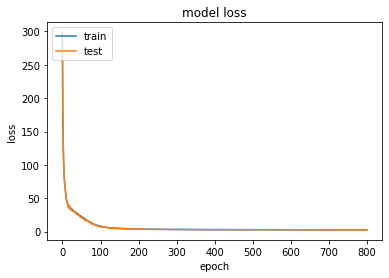

## MODEL SAVED ##


In [59]:
new_cae.train(dataset_emb['train']['x'], dataset['train']['y'], epochs= epochs, verbose=1,
              batch_size=batch_size, callbacks=[earl_stop])

In [60]:
x_encoded = new_cae.encoder.predict(dataset_emb['train']['x'])[0]

Mutual Information Gap : 0.15


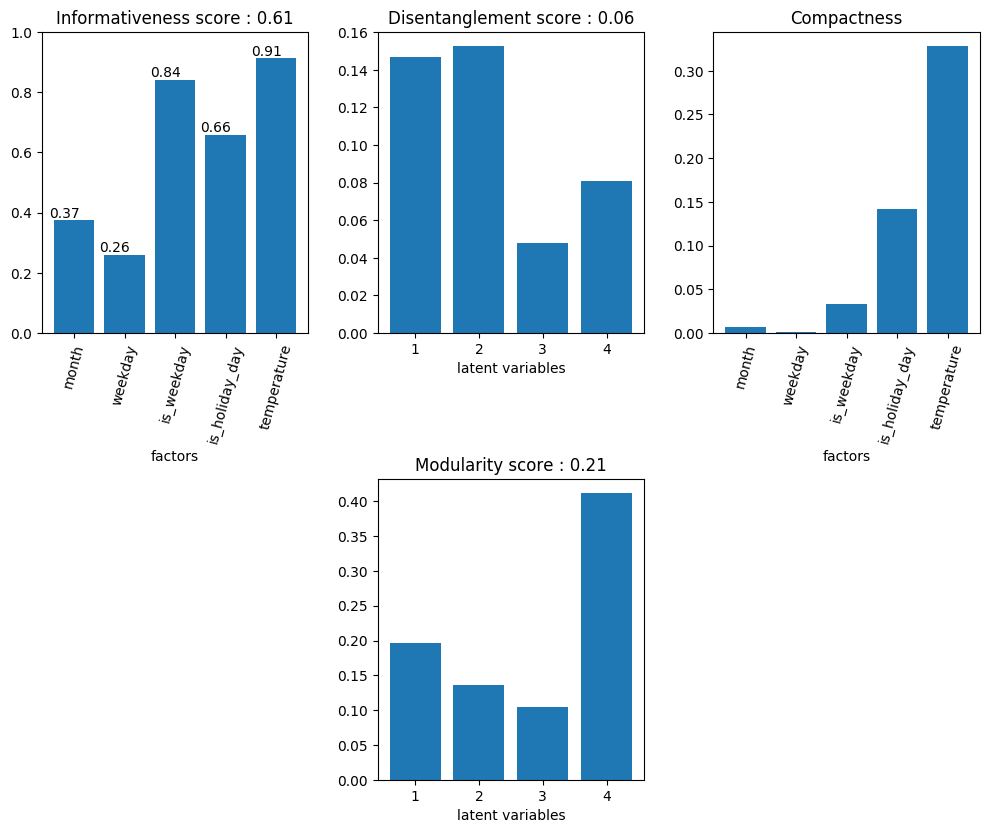

In [61]:
model_eval, importanceMatrix =evaluateLatentCode(x_encoded, factorMatrix, factorDesc, orthogonalize=True, normalize_information=True)
#normalize_information normalise le score avec le minimum obtenu avec une projection aléatoire
display_metrics(model_eval, z_dim, factorDesc)

In [62]:
x_hat = new_cae.model.predict(dataset_emb['train']['x'])[0]

np.mean(np.abs(x_hat - dataset_emb['train']['x'][0]))

0.8995432390204636

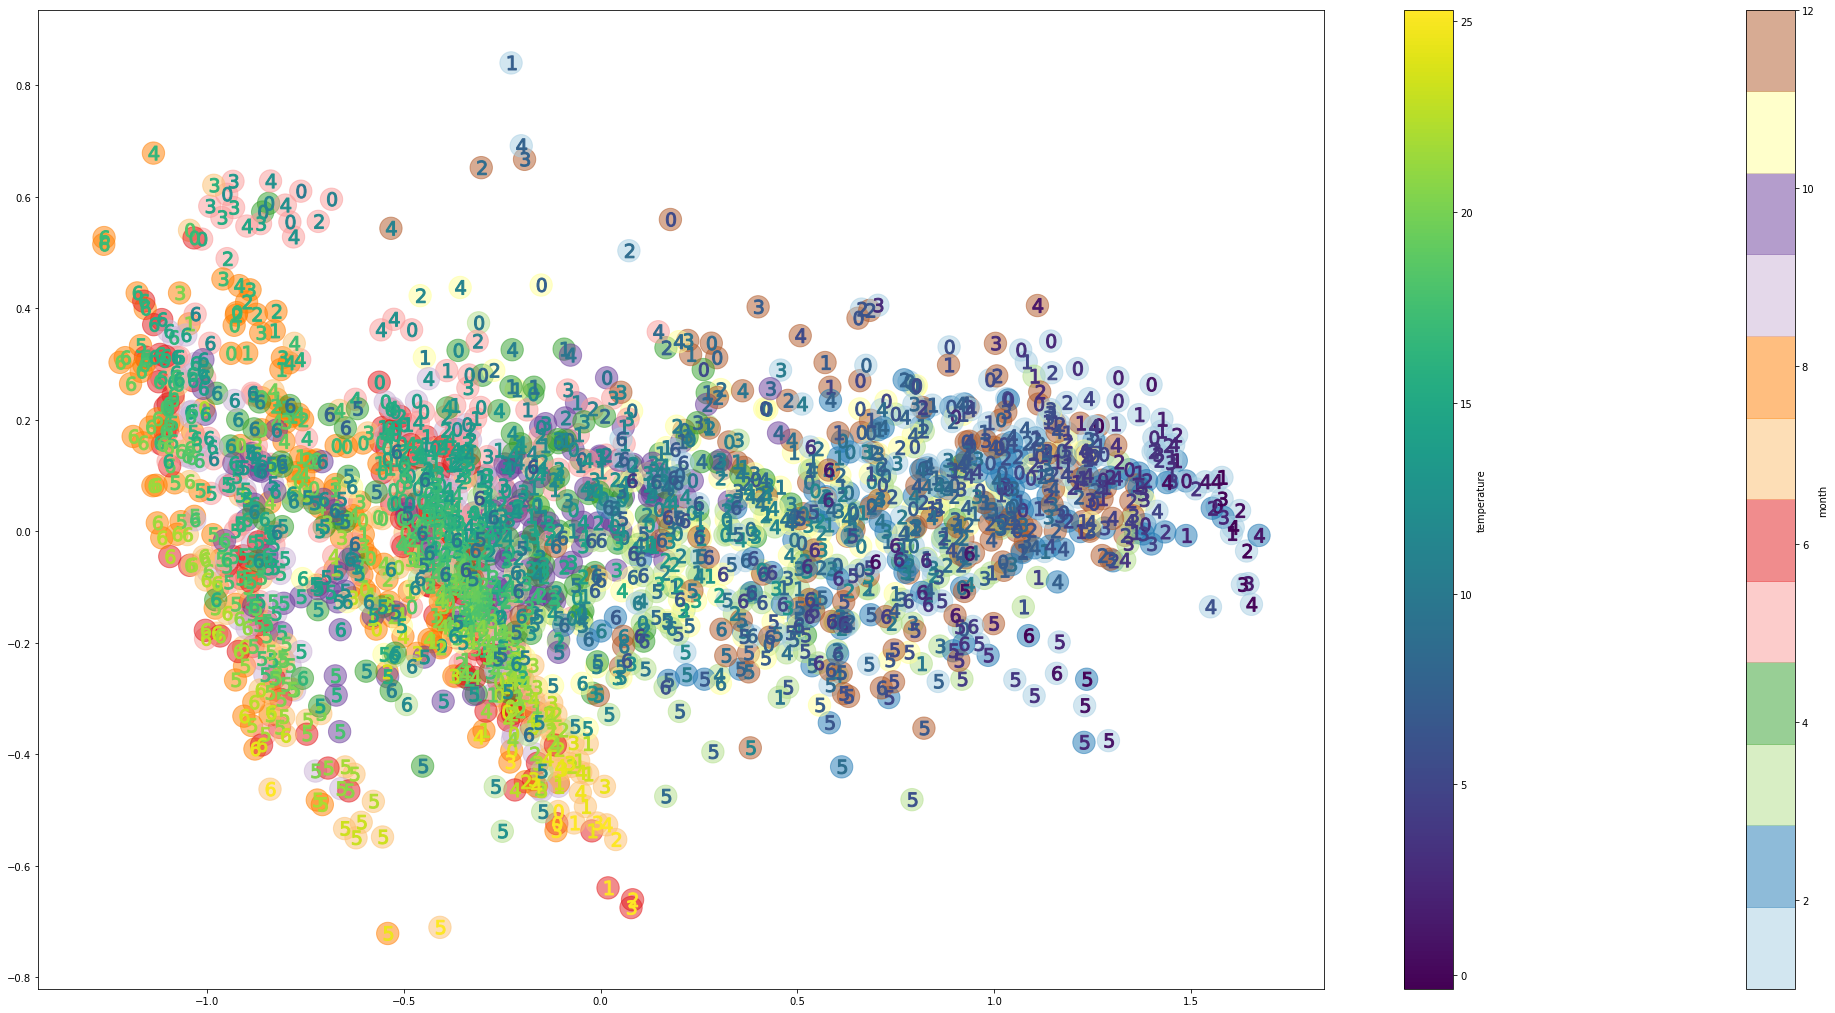

In [63]:
prez_2D(x_encoded)

## Essai de la loss de mutual info

In [40]:
import callbacks
importlib.reload(callbacks)
from callbacks import *

In [28]:
def affinity_matrix(A):
    d0 = A.shape[0]
    d1 = A.shape[1]
    A_tiled1 = np.tile(A.reshape(d0,1,d1), [1,d0,1])
    A_tiled2 = np.tile(A.reshape(1,d0,d1), [d0,1,1])
    gram_A = np.sqrt(np.sum(np.square(A_tiled1 - A_tiled2 ), axis=-1))

    return gram_A

pca_test=PCA(6)
x_pca = pca_test.fit_transform(dataset_emb['train']['x'][0])
y_mat = 1 * (affinity_matrix(x_pca) <=1.5)

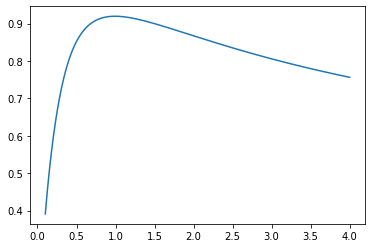

In [29]:
#Trouver le meilleur sigma
sigma = np.linspace(0.1,4, num=300, endpoint=True)

s_test=[]
for s in sigma:
    x_mat = numpy_make_Gram_matrix(dataset_emb['train']['x'][0],s)
    
    s_test.append(np.trace(np.matmul(x_mat,y_mat.T))/(np.linalg.norm(x_mat, "fro")*np.linalg.norm(y_mat, "fro")))
sop=sigma[np.argmax(s_test)]
    
plt.plot(sigma, s_test)

In [30]:
sop

0.9869565217391304

In [32]:
#root git folder 
name_model="cvae_mutualinfo"
vae_params = VAE_params(name=name_model, out_dir = log_dir_model)

vae_params.set_model_params()
vae_params.set_training_params()

Default values for model architecture are:
cond_dims  :=  []
cond_insert  :=  ['encoder', 'decoder']
with_embedding  :=  False
emb_dims  :=  []
reparametrize  :=  GaussianSampling
input_dims  :=  48
output_dims  :=  48
latent_dims  :=  4
nb_latent_components  :=  2
nb_encoder_ensemble  :=  1
encoder_dims  :=  [48, 48, 24, 12]
encoder_type  :=  NNBlockCond_model
nb_decoder_outputs  :=  1
nb_decoder_ensemble  :=  1
decoder_dims  :=  [12, 24, 48, 48]
decoder_type  :=  InceptionBlock_model
Default parameters for training are a L2 loss with Adam optimizer with a learning rate of 0.0003


In [33]:
vae_params.model_params.encoder_dims = e_dims
vae_params.model_params.decoder_dims = d_dims
vae_params.model_params.cond_dims = cond_to_emb
vae_params.model_params.cond_insert=['decoder']
vae_params.model_params.with_embedding = True
vae_params.model_params.emb_dims = [[36,22,10],[12,4],[],6]
vae_params.model_params.nb_encoder_ensemble = 1


loss_weights = {"recon_loss" : 1, "kl_loss" : 0.3, "info_loss":66}

vae_loss = loss_class.VAELoss(loss_weights = loss_weights, custom_loss=None)
vae_loss.options["scale"] = sop
vae_params.training_params.loss = vae_loss
vae_params.training_params.lr = 1e-5

In [53]:
mi_cvae=CVAE(vae_params)
mi_cvae.VAE_params.model_params.cond_insert

['decoder']

In [54]:
mi_cvae.build_model(vae_params)

Model: "cvae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_inputs (InputLayer)           [(None, 48)]         0                                            
__________________________________________________________________________________________________
cond_inputs_0 (InputLayer)      [(None, 48)]         0                                            
__________________________________________________________________________________________________
cond_inputs_1 (InputLayer)      [(None, 12)]         0                                            
__________________________________________________________________________________________________
cond_inputs_2 (InputLayer)      [(None, 1)]          0                                            
_______________________________________________________________________________________________

In [36]:
epochs=500

In [37]:
from tensorflow.keras.callbacks import EarlyStopping
earl_stop = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=200, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)


In [55]:
               
histinfo = InformationHistory(scale=sop,alpha=1.01,dataset_train=dataset_emb['train']['x'],
                              cond_insert = mi_cvae.VAE_params.model_params.cond_insert,
                              period=np.unique(np.logspace(0,4,endpoint=True, num=500, dtype=int)),
                              infotoeval=["XZ", "X(C+Z)", "CZ", "CEmb", "XX'"], printlogger=True)

## START TRAINING ##
Mutual informations for epoch 1 are XZ :  0.311 ; X(C+Z) :  141.924 ; CZ :  -0.595 ; CEmb :  101.777 ; XX' :  13.590
Mutual informations for epoch 2 are XZ :  0.427 ; X(C+Z) :  142.261 ; CZ :  -0.771 ; CEmb :  86.766 ; XX' :  2.102
Mutual informations for epoch 3 are XZ :  0.530 ; X(C+Z) :  142.620 ; CZ :  -0.947 ; CEmb :  74.527 ; XX' :  -4.247
Mutual informations for epoch 4 are XZ :  0.633 ; X(C+Z) :  142.869 ; CZ :  -0.998 ; CEmb :  65.549 ; XX' :  -3.371
Mutual informations for epoch 5 are XZ :  0.663 ; X(C+Z) :  143.096 ; CZ :  -1.060 ; CEmb :  56.463 ; XX' :  -16.801
Mutual informations for epoch 6 are XZ :  0.692 ; X(C+Z) :  143.359 ; CZ :  -1.177 ; CEmb :  45.853 ; XX' :  -7.128
Mutual informations for epoch 7 are XZ :  0.718 ; X(C+Z) :  143.631 ; CZ :  -1.303 ; CEmb :  37.315 ; XX' :  -19.748
Mutual informations for epoch 8 are XZ :  0.781 ; X(C+Z) :  143.946 ; CZ :  -1.480 ; CEmb :  31.691 ; XX' :  -25.749
Mutual informations for epoch 9 are XZ :  0.881 

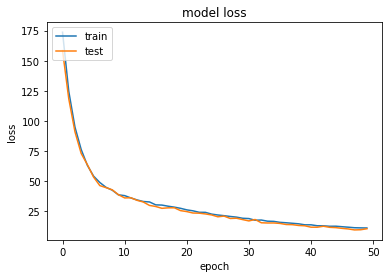

## MODEL SAVED ##


In [56]:
mi_cvae.train(dataset_emb['train']['x'], dataset['train']['y'], epochs= 50, verbose=0,
              batch_size=batch_size, callbacks=[earl_stop, histinfo])

In [57]:
mi_cvae.maketrainable(modelpart=['encoder'], boolean=True)
mi_cvae.maketrainable(modelpart=['decoder'], boolean=False)
mi_cvae.maketrainable(modelpart=['cond_embedding'], boolean=True)

Change trainable status of encoder layers
Change trainable status of decoder layers
Change trainable status of cond_embedding layers


In [59]:
for lay in mi_cvae.decoder.layers:
    print(lay.trainable)

False
False
False
False
True
False
False


In [46]:
for i in ['model','encoder', 'decoder', 'cond_embedding']:
    getattr(mi_cvae,i).summary()

Model: "cvae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_inputs (InputLayer)           [(None, 48)]         0                                            
__________________________________________________________________________________________________
cond_inputs_0 (InputLayer)      [(None, 48)]         0                                            
__________________________________________________________________________________________________
cond_inputs_1 (InputLayer)      [(None, 12)]         0                                            
__________________________________________________________________________________________________
cond_inputs_2 (InputLayer)      [(None, 1)]          0                                            
_______________________________________________________________________________________________

## START TRAINING ##
Mutual informations for epoch 51 are XZ :  15.329 ; X(C+Z) :  146.306 ; CZ :  17.206 ; CEmb :  3.069 ; XX' :  53.613
Mutual informations for epoch 52 are XZ :  15.429 ; X(C+Z) :  146.313 ; CZ :  17.330 ; CEmb :  3.069 ; XX' :  54.913
Mutual informations for epoch 53 are XZ :  15.499 ; X(C+Z) :  146.314 ; CZ :  17.439 ; CEmb :  3.069 ; XX' :  55.181
Mutual informations for epoch 54 are XZ :  15.550 ; X(C+Z) :  146.314 ; CZ :  17.536 ; CEmb :  3.069 ; XX' :  56.606
Mutual informations for epoch 55 are XZ :  15.590 ; X(C+Z) :  146.312 ; CZ :  17.605 ; CEmb :  3.069 ; XX' :  55.583
Mutual informations for epoch 56 are XZ :  15.704 ; X(C+Z) :  146.319 ; CZ :  17.727 ; CEmb :  3.069 ; XX' :  57.601
Mutual informations for epoch 58 are XZ :  16.095 ; X(C+Z) :  146.336 ; CZ :  18.208 ; CEmb :  3.069 ; XX' :  57.721
Mutual informations for epoch 59 are XZ :  16.239 ; X(C+Z) :  146.344 ; CZ :  18.359 ; CEmb :  3.069 ; XX' :  55.766
Mutual informations for epoch 60 are XZ :  

Mutual informations for epoch 189 are XZ :  13.170 ; X(C+Z) :  145.799 ; CZ :  13.726 ; CEmb :  3.069 ; XX' :  47.682
Mutual informations for epoch 192 are XZ :  12.987 ; X(C+Z) :  145.793 ; CZ :  13.550 ; CEmb :  3.069 ; XX' :  47.986
Mutual informations for epoch 196 are XZ :  12.774 ; X(C+Z) :  145.778 ; CZ :  13.284 ; CEmb :  3.069 ; XX' :  48.355
Mutual informations for epoch 199 are XZ :  12.540 ; X(C+Z) :  145.771 ; CZ :  12.979 ; CEmb :  3.069 ; XX' :  47.595
Mutual informations for epoch 203 are XZ :  12.298 ; X(C+Z) :  145.768 ; CZ :  12.709 ; CEmb :  3.069 ; XX' :  47.698
Mutual informations for epoch 207 are XZ :  12.134 ; X(C+Z) :  145.767 ; CZ :  12.557 ; CEmb :  3.069 ; XX' :  48.117
Mutual informations for epoch 211 are XZ :  11.888 ; X(C+Z) :  145.786 ; CZ :  12.313 ; CEmb :  3.069 ; XX' :  47.874
Mutual informations for epoch 215 are XZ :  11.724 ; X(C+Z) :  145.792 ; CZ :  12.148 ; CEmb :  3.069 ; XX' :  47.602
Mutual informations for epoch 219 are XZ :  11.661 ; X(C

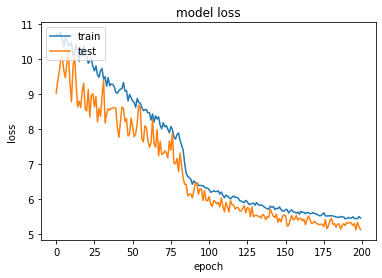

## MODEL SAVED ##


In [60]:
mi_cvae.train(dataset_emb['train']['x'], dataset['train']['y'], epochs= 200, verbose=0,
              batch_size=batch_size, callbacks=[histinfo])

In [61]:
cond_emb = mi_cvae.cond_embedding.predict(dataset_emb['train']['x'][1:])

Mutual Information Gap : 0.33


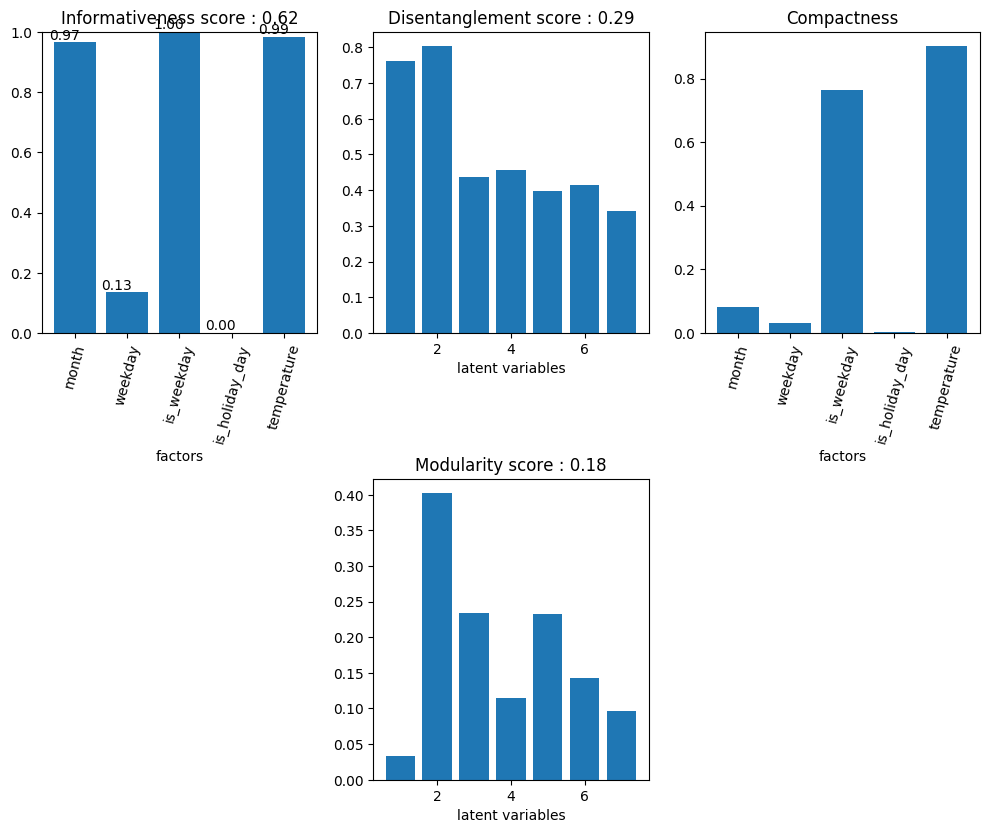

In [62]:
model_eval, importanceMatrix =evaluateLatentCode(cond_emb, factorMatrix, factorDesc, orthogonalize=True, normalize_information=True)
#normalize_information normalise le score avec le minimum obtenu avec une projection aléatoire
display_metrics(model_eval, 7, factorDesc)

In [65]:
mi_cvae.maketrainable(modelpart=['decoder'], boolean=True)
mi_cvae.maketrainable(modelpart=['cond_embedding'], boolean=False)
for lay in mi_cvae.decoder.get_layer("cond_emb").layers:
    print(lay.trainable)
for lay in mi_cvae.encoder.layers:
    print(lay.trainable)

Change trainable status of decoder layers
Change trainable status of cond_embedding layers
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True


## START TRAINING ##
Mutual informations for epoch 253 are XZ :  10.974 ; X(C+Z) :  145.800 ; CZ :  11.479 ; CEmb :  3.069 ; XX' :  47.555
Mutual informations for epoch 258 are XZ :  9.765 ; X(C+Z) :  145.733 ; CZ :  10.037 ; CEmb :  3.069 ; XX' :  47.032
Mutual informations for epoch 263 are XZ :  8.641 ; X(C+Z) :  145.675 ; CZ :  8.712 ; CEmb :  3.069 ; XX' :  47.397
Mutual informations for epoch 268 are XZ :  7.485 ; X(C+Z) :  145.596 ; CZ :  7.375 ; CEmb :  3.069 ; XX' :  47.906
Mutual informations for epoch 273 are XZ :  6.389 ; X(C+Z) :  145.511 ; CZ :  6.102 ; CEmb :  3.069 ; XX' :  47.494
Mutual informations for epoch 278 are XZ :  5.415 ; X(C+Z) :  145.430 ; CZ :  4.941 ; CEmb :  3.069 ; XX' :  47.844
Mutual informations for epoch 283 are XZ :  4.751 ; X(C+Z) :  145.365 ; CZ :  4.105 ; CEmb :  3.069 ; XX' :  47.447
Mutual informations for epoch 289 are XZ :  4.006 ; X(C+Z) :  145.247 ; CZ :  3.161 ; CEmb :  3.069 ; XX' :  47.313
Mutual informations for epoch 294 are XZ :  3.65

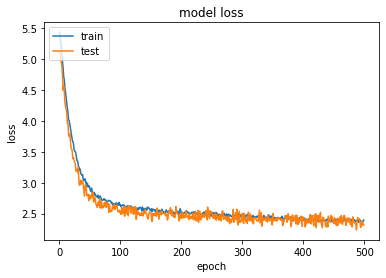

## MODEL SAVED ##


In [66]:
mi_cvae.train(dataset_emb['train']['x'], dataset['train']['y'], epochs= epochs, verbose=0,
              batch_size=batch_size, callbacks=[earl_stop, histinfo])

Mutual Information Gap : 0.07


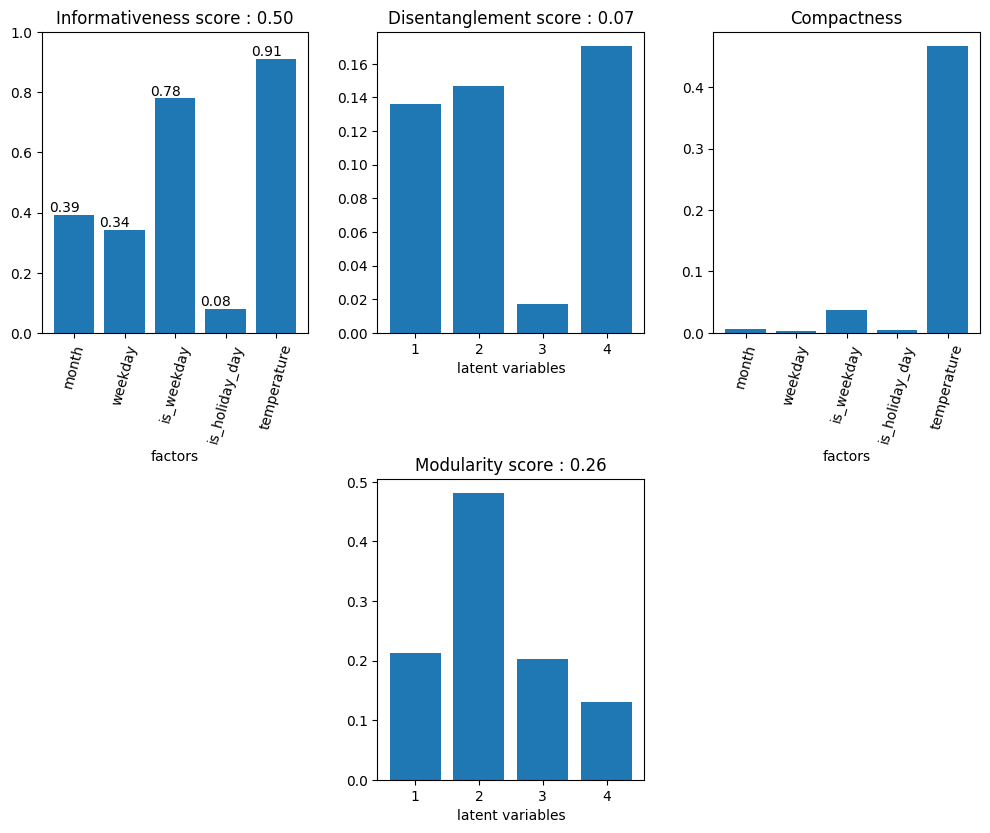

In [67]:
x_encoded = mi_cvae.encoder.predict(dataset_emb['train']['x'])[0]
model_eval, importanceMatrix =evaluateLatentCode(x_encoded, factorMatrix, factorDesc, orthogonalize=True, normalize_information=True)
#normalize_information normalise le score avec le minimum obtenu avec une projection aléatoire
display_metrics(model_eval, z_dim, factorDesc)

In [68]:
#mi_cvae.save()
loss_weights = {"recon_loss" : 1, "kl_loss" : 0.67, "info_loss" : 66, "mutualinfo_loss":10}

vae_loss = loss_class.VAELoss(loss_weights = loss_weights, custom_loss=None,
                             options={"prior_mu":0., "log_prior_sigma":0., "kl_annealing":0., "alpha":1.01, "scale":sop})
vae_params.training_params.loss = vae_loss
vae_params.training_params.lr = 1e-5
vae_params.training_params.log_prior_sigma = [-2.,-1.,0.,1.]


In [69]:
mi_cvae.load_model(retrieve_model_architecture=False, training_params=vae_params.training_params)

## START TRAINING ##
Mutual informations for epoch 754 are XZ :  3.610 ; X(C+Z) :  144.241 ; CZ :  3.836 ; CEmb :  3.069 ; XX' :  60.305
Mutual informations for epoch 768 are XZ :  4.122 ; X(C+Z) :  144.326 ; CZ :  4.519 ; CEmb :  3.069 ; XX' :  66.069
Mutual informations for epoch 783 are XZ :  4.578 ; X(C+Z) :  144.390 ; CZ :  5.137 ; CEmb :  3.069 ; XX' :  69.652
Mutual informations for epoch 797 are XZ :  4.940 ; X(C+Z) :  144.433 ; CZ :  5.584 ; CEmb :  3.069 ; XX' :  69.739
Mutual informations for epoch 812 are XZ :  5.236 ; X(C+Z) :  144.475 ; CZ :  6.013 ; CEmb :  3.069 ; XX' :  70.976
Mutual informations for epoch 827 are XZ :  5.510 ; X(C+Z) :  144.507 ; CZ :  6.391 ; CEmb :  3.069 ; XX' :  72.386
Mutual informations for epoch 843 are XZ :  5.751 ; X(C+Z) :  144.532 ; CZ :  6.734 ; CEmb :  3.069 ; XX' :  72.822
Mutual informations for epoch 858 are XZ :  5.936 ; X(C+Z) :  144.552 ; CZ :  7.029 ; CEmb :  3.069 ; XX' :  73.704
Mutual informations for epoch 874 are XZ :  6.188 ;

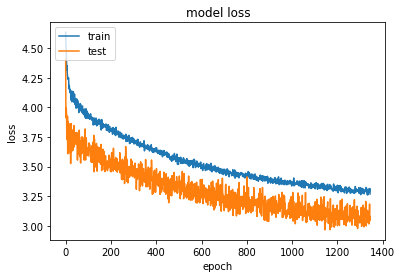

## MODEL SAVED ##


In [70]:
mi_cvae.train(dataset_emb['train']['x'], dataset['train']['y'], epochs= 2000, verbose=0,
              batch_size=128, callbacks=[earl_stop, histinfo])

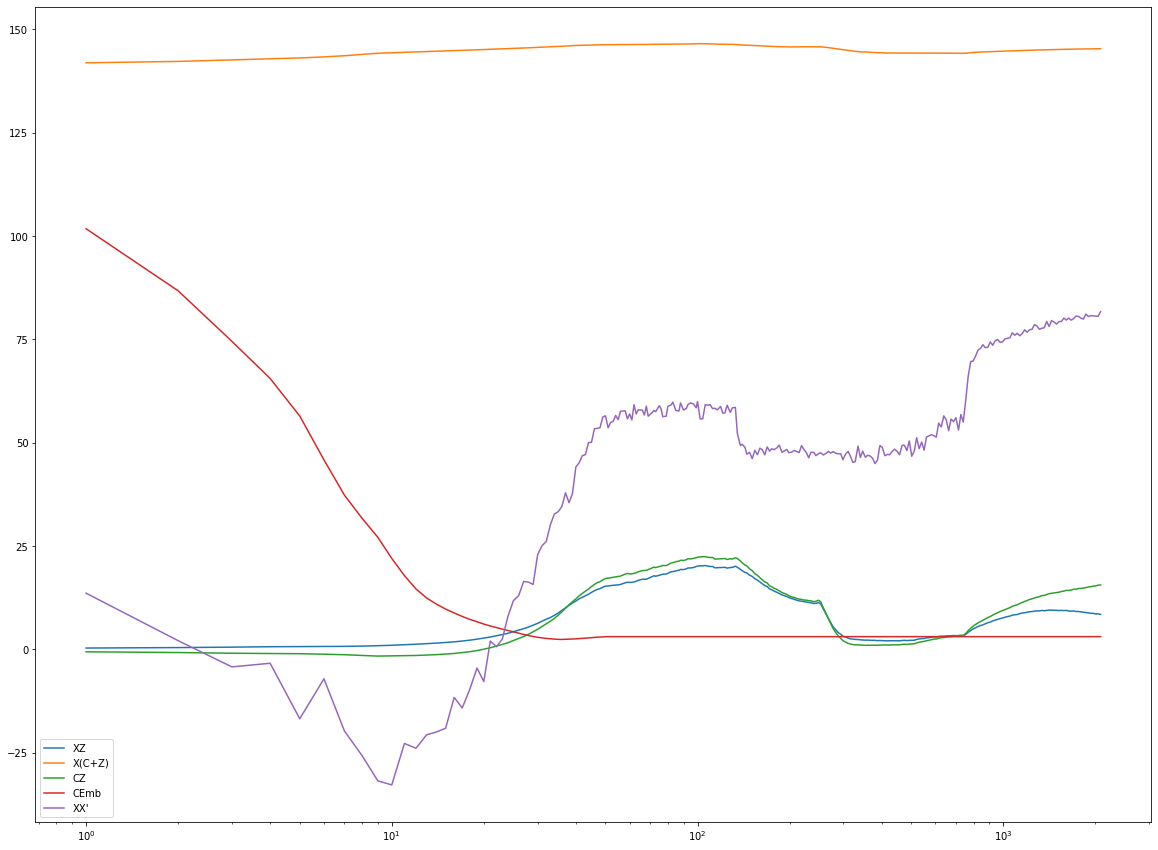

In [72]:
plt.figure(figsize=(20,15))
for key, list_val in histinfo.MI.items():
    plt.plot(histinfo.period[:len(list_val)], list_val, label=key)
plt.xscale("log")
plt.legend()

In [73]:
x_encoded = mi_cvae.encoder.predict(dataset_emb['train']['x'])[0]

Mutual Information Gap : 0.06


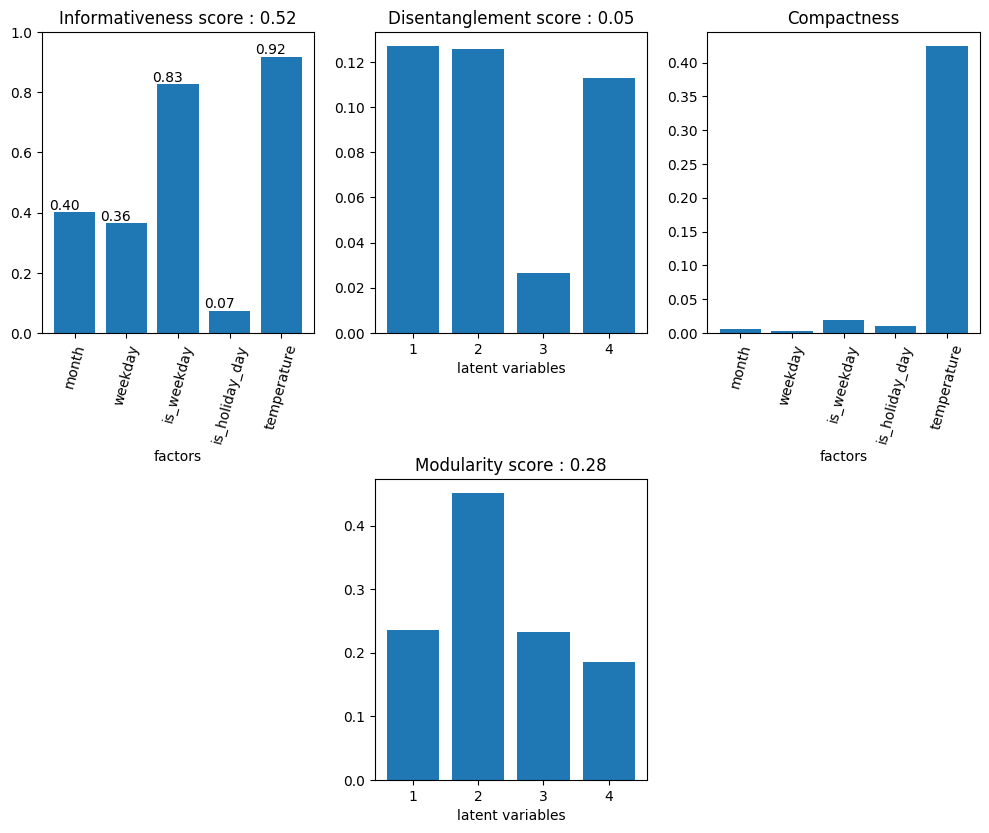

In [74]:
model_eval, importanceMatrix =evaluateLatentCode(x_encoded, factorMatrix, factorDesc, orthogonalize=True, normalize_information=True)
#normalize_information normalise le score avec le minimum obtenu avec une projection aléatoire
display_metrics(model_eval, z_dim, factorDesc)

In [75]:
x_hat = mi_cvae.model.predict(dataset_emb['train']['x'])[0]

np.mean(np.abs(x_hat - dataset_emb['train']['x'][0]))

0.890592336817349

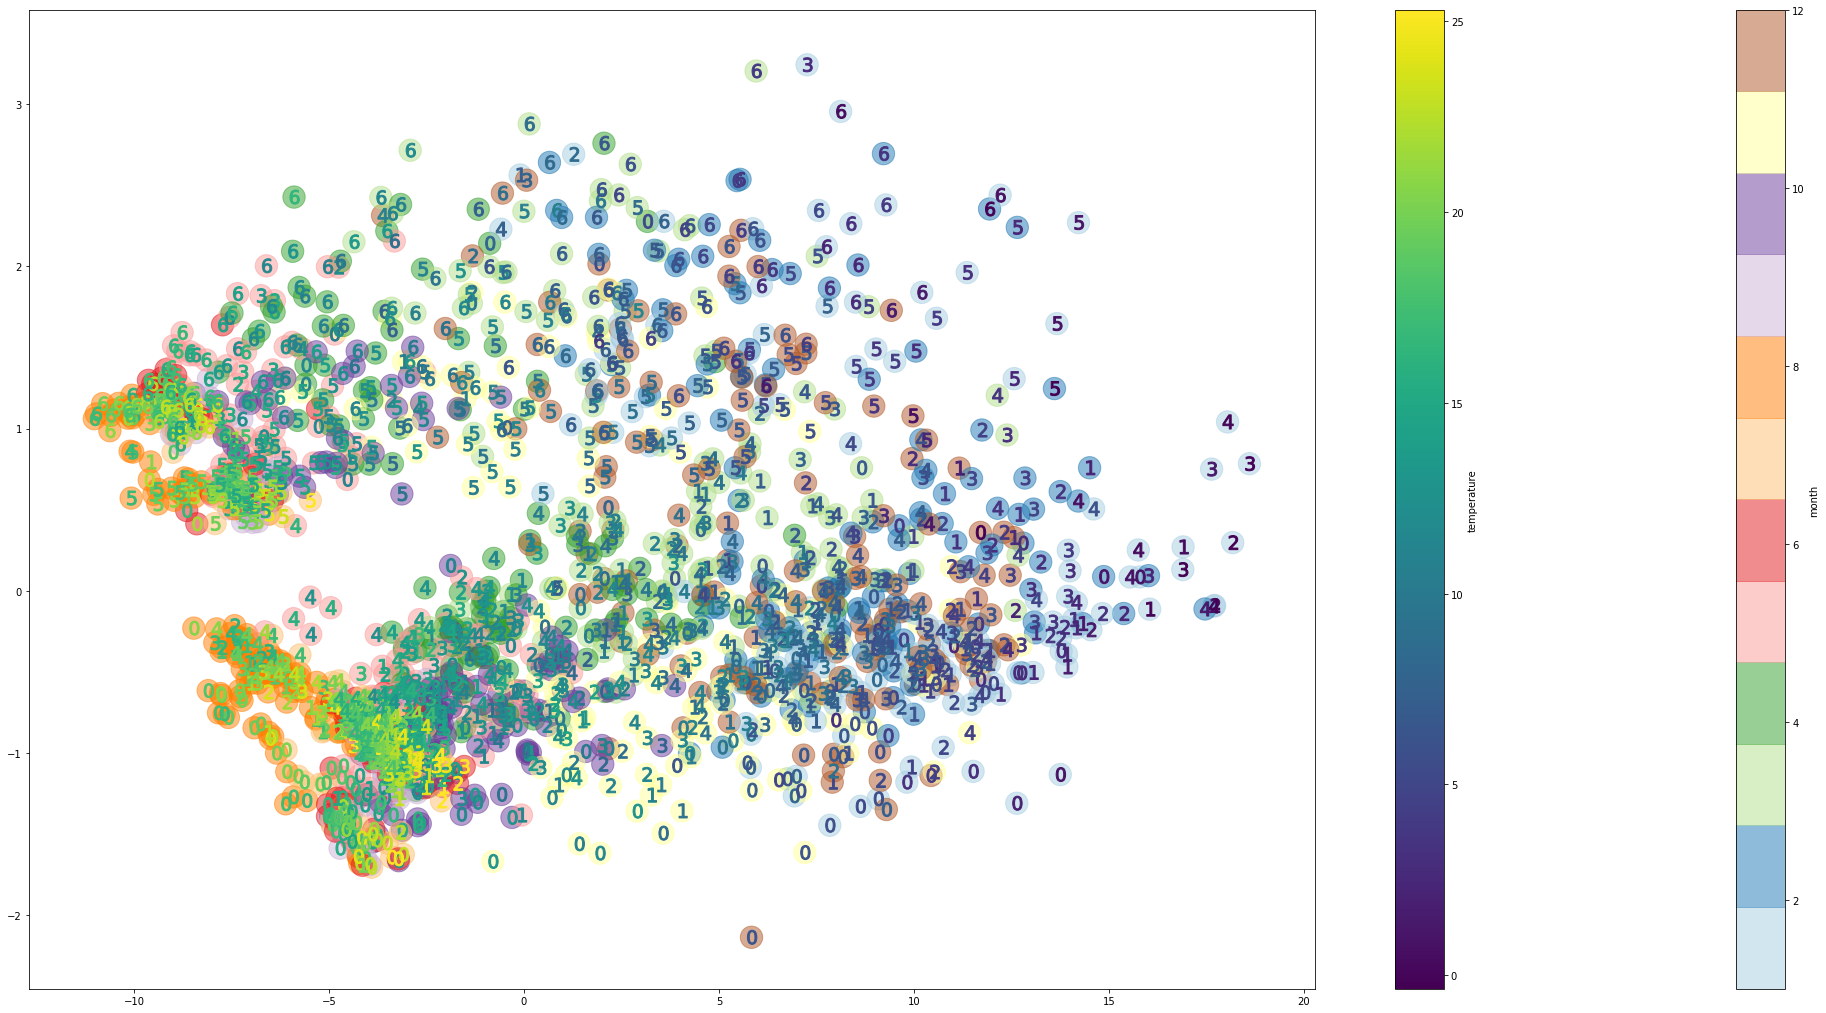

In [76]:
prez_2D(x_pca)